## New features in Isolation Forest: contamination ratio and using validation frame

We will demonstrate how to use contamination parameter to get predicted labels out of an Isolation Forest model. We will also experiment with a new feature added the algorithm - using a validation frame to check quality of the model and do early stopping.

Using validation frame is still an experimental feauture in active development. Please send us your feedback and we will try to incorporate your comments!

Please also be careful about your conclusions based on experiments with this notebook. The notebook is intentionally not seeded and we encourage you to rerun the experiments several times to see how different random inputs changes the performance of the model.

In [1]:
import sys
import h2o
from h2o.frame import H2OFrame
import numpy as np
import pandas as pd

In [2]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,52 mins 37 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.31.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,mkurka
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.276 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Generate some synthetic data

In [3]:
N = 1000
cont = 0.05 # ratio of outliers/anomalies

In [4]:
regular_data = np.random.normal(0, 0.5, (int(N*(1-cont)), 2))
anomaly_data = np.column_stack((np.random.normal(-1.5, 1, int(N*cont)), np.random.normal(1.5, 1, int(N*cont))))

In [5]:
import matplotlib.pyplot as plt

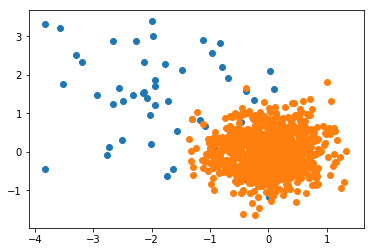

In [6]:
plt.scatter(anomaly_data[:,0], anomaly_data[:,1])
plt.scatter(regular_data[:,0], regular_data[:,1])
plt.show()

In [7]:
regular_pd = pd.DataFrame({'x': regular_data[:, 0], 'y': regular_data[:, 1], 'label': np.zeros(regular_data.shape[0])})
anomaly_pd = pd.DataFrame({'x': anomaly_data[:, 0], 'y': anomaly_data[:, 1], 'label': np.ones(anomaly_data.shape[0])})

In [8]:
dataset = H2OFrame(regular_pd.append(anomaly_pd).sample(frac=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
train_with_label, test = dataset.split_frame([0.8])

In [10]:
train_with_label["label"].table()

label,Count
0,756
1,39


In [11]:
test["label"].table()

label,Count
0,194
1,11


In [12]:
train = train_with_label.drop(["label"])
test["label"] = test["label"].asfactor()

In [13]:
from h2o.estimators.isolation_forest import H2OIsolationForestEstimator

### Train Isolation Forest with a validation set

We will use validation frame and enable early stopping. The observations of validation frame are labeled and anomalies/outliers are marked with label "1", regular observations with "0". This lets us use binomial classification metrics to do early stopping. The model will calculate binomial metrics on the validation frame and use early stopping based on the performance observed on the validation data.

In [14]:
if_model = H2OIsolationForestEstimator(seed=12, ntrees=200,
                                       score_tree_interval=7, stopping_rounds=3, stopping_metric="mean_per_class_error",
                                       validation_response_column="label")
if_model.train(training_frame=train, validation_frame=test)

isolationforest Model Build progress: |███████████████████████████████████| 100%


The trained model will have different kind of metrics for training and validation frame. For training - where we don't have labeled data - anomaly metrics will be returned. For validation frame we will see binomial model metrics.

In [15]:
if_model

Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1593529508000_107


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,56.0,56.0,39085.0,8.0,8.0,8.0,25.0,78.0,50.767857




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.77065108782
Normalized Anomaly Score: 0.0467037784801

ModelMetricsBinomial: isolationforest
** Reported on validation data. **

MSE: 0.0547974682524
RMSE: 0.234088590607
LogLoss: 0.188428153792
Mean Per-Class Error: 0.157919400187
AUC: 0.832474226804
AUCPR: 0.256449326499
Gini: 0.664948453608

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.145454545455: 


,,0,1,Error,Rate
0,0,184.0,10.0,0.0515,(10.0/194.0)
1,1,4.0,7.0,0.3636,(4.0/11.0)
2,Total,188.0,17.0,0.0683,(14.0/205.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.145455,0.500000,13.0
1,max f2,0.145455,0.573770,13.0
2,max f0point5,0.167273,0.476190,10.0
3,max accuracy,0.778182,0.941463,0.0
4,max precision,0.167273,0.461538,10.0
5,max recall,0.003636,1.000000,46.0
6,max specificity,0.778182,0.994845,0.0
7,max absolute_mcc,0.145455,0.477875,13.0
8,max min_per_class_accuracy,0.080000,0.818182,25.0
9,max mean_per_class_accuracy,0.080000,0.842081,25.0



Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-06-30 11:57:47,0.001 sec,0.0,NaN,NaN
1,,2020-06-30 11:57:47,0.031 sec,7.0,6.777928,0.044414
2,,2020-06-30 11:57:47,0.062 sec,14.0,6.764469,0.048492
3,,2020-06-30 11:57:47,0.097 sec,21.0,6.769009,0.047557
4,,2020-06-30 11:57:47,0.124 sec,28.0,6.763426,0.049805
5,,2020-06-30 11:57:47,0.152 sec,35.0,6.770500,0.045900
6,,2020-06-30 11:57:47,0.179 sec,42.0,6.772585,0.045267
7,,2020-06-30 11:57:47,0.211 sec,49.0,6.770547,0.046268
8,,2020-06-30 11:57:47,0.229 sec,56.0,6.770651,0.046704


In [16]:
predicted = if_model.predict(train)
predicted.head()

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,score,mean_length
0,0.123636,6.39286
0,0,7
0,0.0145455,6.92857
1,0.421818,4.92857
0,0.0509091,6.75
0,0.0181818,6.91071
0,0,7
0,0.00727273,6.96429
0,0.134545,6.33929
0,0,7


The output incudes predicted class of the observation not anomaly/anomaly. This is accomplished by using the validation frame. In current implementation we pick the threshold to maximize the F1 score.

In [17]:
predicted_train_labels = predicted["predict"].as_data_frame(use_pandas=True)
train_pd = train.as_data_frame(use_pandas=True)

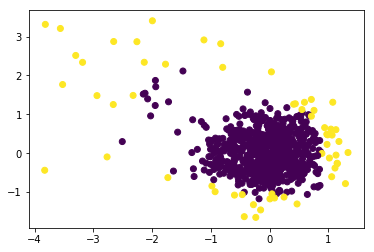

In [18]:
plt.scatter(train_pd["x"], train_pd["y"], c=predicted_train_labels["predict"])
plt.show()

In [19]:
if_model.model_performance(train_with_label)


ModelMetricsBinomial: isolationforest
** Reported on test data. **

MSE: 0.0436448796715
RMSE: 0.20891356986
LogLoss: 0.138389352082
Mean Per-Class Error: 0.105667480667
AUC: 0.936440103107
AUCPR: 0.348593089161
Gini: 0.872880206214

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0909090909091: 


,,0,1,Error,Rate
0,0,692.0,64.0,0.0847,(64.0/756.0)
1,1,8.0,31.0,0.2051,(8.0/39.0)
2,Total,700.0,95.0,0.0906,(72.0/795.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.090909,0.462687,53.0
1,max f2,0.076364,0.629771,56.0
2,max f0point5,0.138182,0.406360,41.0
3,max accuracy,0.927273,0.953459,1.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.018182,1.000000,72.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.076364,0.476273,56.0
8,max min_per_class_accuracy,0.065455,0.871795,59.0
9,max mean_per_class_accuracy,0.043636,0.894333,65.0


### Train Isolation Forest using contamination parameter

In [20]:
if_model_cont = H2OIsolationForestEstimator(seed=12, contamination=cont)
if_model_cont.train(training_frame=train)
if_model_cont

/Users/mkurka/git/h2o/h2o-3/h2o-py/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1593529508000_108


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,34937.0,8.0,8.0,8.0,25.0,78.0,50.84




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.77064148276
Normalized Anomaly Score: 0.0458717034484

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-06-30 11:57:48,0.003 sec,0.0,NaN,NaN
1,,2020-06-30 11:57:48,0.012 sec,1.0,6.864504,0.019357
2,,2020-06-30 11:57:48,0.034 sec,2.0,6.851371,0.027023
3,,2020-06-30 11:57:48,0.057 sec,3.0,6.820479,0.029920
4,,2020-06-30 11:57:48,0.080 sec,4.0,6.805021,0.038996
5,,2020-06-30 11:57:48,0.092 sec,5.0,6.807712,0.035609
6,,2020-06-30 11:57:48,0.100 sec,6.0,6.783165,0.043367
7,,2020-06-30 11:57:48,0.108 sec,7.0,6.777928,0.044414
8,,2020-06-30 11:57:48,0.115 sec,8.0,6.776496,0.048325
9,,2020-06-30 11:57:48,0.127 sec,9.0,6.782595,0.044469



See the whole table with table.as_data_frame()


In [21]:
predicted_train_labels_cont = if_model_cont.predict(train)["predict"].as_data_frame(use_pandas=True)

isolationforest prediction progress: |████████████████████████████████████| 100%


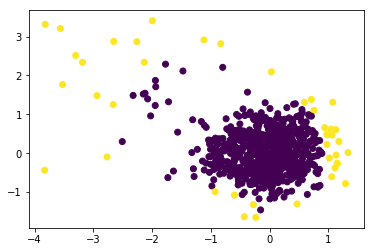

In [22]:
plt.scatter(train_pd["x"], train_pd["y"], c=predicted_train_labels_cont["predict"])
plt.show()